In [18]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.layers import Conv2D,UpSampling2D,Input,BatchNormalization,ReLU,Conv2DTranspose,Softmax
from keras.layers.merge import concatenate
from keras.layers import Activation, Dense 
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
from glob import glob

In [31]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!unzip '/content/drive/MyDrive/Images.zip'

Archive:  /content/drive/MyDrive/Images.zip
   creating: Images/
  inflating: Images/.DS_Store        
  inflating: Images/sun_bojywhwufsckphfa.jpg  
  inflating: Images/sun_btjjalgedyognjhs.jpg  
  inflating: Images/sun_browhtghljbzuemv.jpg  
  inflating: Images/sun_brqzquxbptvmorgv.jpg  
  inflating: Images/sun_bsqdotytertcpxjc.jpg  
  inflating: Images/sun_bolfhwtizbvyjmem.jpg  
  inflating: Images/sun_bvoraywiwkghtfsp.jpg  
  inflating: Images/sun_btpaxygvjiqfrsvs.jpg  
  inflating: Images/sun_bvqtjyvvsgrcazvx.jpg  
  inflating: Images/sun_bsehgeimmwxomwfa.jpg  
  inflating: Images/sun_brvzopcyvrklmmqg.jpg  
  inflating: Images/sun_bpwkqeughwjptkae.jpg  
  inflating: Images/sun_btujhlvsnthushcq.jpg  
  inflating: Images/sun_bsssizmsssfovgzv.jpg  
  inflating: Images/sun_btyesquxyytxifkc.jpg  
  inflating: Images/sun_btjcdpubjyksltie.jpg  
  inflating: Images/sun_bsqlhpesrcwkeozl.jpg  
  inflating: Images/sun_bqsghgrqmowmzmks.jpg  
  inflating: Images/sun_bslafxlsqsoszwfp.jpg  
  in

In this model we used sundata set from assignment 4(BOVW)

In [33]:
Image_path = '../content/Images'

In [34]:
data = glob(os.path.join(Image_path,'*.jpg'))

In [35]:
len(data),data[0]

(720, '../content/Images/sun_acovjwvjhmqsprye.jpg')

# Convert all training images from the RGB color space to the Lab color space



In [36]:
HEIGHT=224
WIDTH=224

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for im in path:
        try:
            img = cv2.imread(im)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))
            
            img_lab_rs_norm = (img_lab_rs -[0,0,0])/[100,110,110]
            
            #Extracting the l and ab channel
            img_l = img_lab_rs_norm[:,:,0]
            img_ab = img_lab_rs_norm[:,:,1:]
            
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    return X_img,y_img

In image colorization, our goal is to produce a colored image given a grayscale input image. This problem is challenging because it is multimodal -- a single grayscale image may correspond to many plausible colored images.

In [37]:
X_,y_ = ExtractInput(data) # Data-preprocessing

we will only work with images of size 224 x 224, so our inputs are of size 224 x 224 x 1 (the lightness channel) and our outputs are of size 224 x 224 x 2 (the other two channels).

In [38]:
X_.shape,y_.shape

((720, 224, 224), (720, 224, 224, 2))

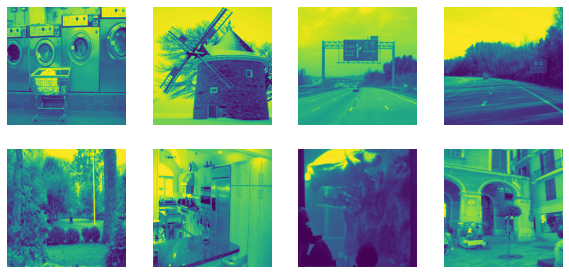

In [39]:
plt.figure(figsize=(10,10))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(X_[i])

We'll try to predict the color values of the input image directly (that is, we do regression).

We'll build and train our model with tensorflow. We'll also use keras, a helpful set of tools for working with images, and scikit-learn for converting between RGB and LAB colorspces

## Model
We follow this [Automatic Image Colorization with Simultaneous Classification](http://iizuka.cs.tsukuba.ac.jp/projects/colorization/data/colorization_sig2016.pdf).We perform regression on the values of `a and b` channel.
<img src="model2.png">

Our model is a convolutional neural network. We first apply a number of convolutional layers to extract features from our image, and then we apply deconvolutional layers to upscale (increase the spacial resolution) of our features.


Architectures of the different networks used in our model. Fully-Connected (FC) layers refer to the standard neural network layers, The output layer consists of a convolutional layer with ReLU transfer layer. Outputs refers to the number of output channels for the output of the layer. Upsample layers consist of using the nearestneighbour approach to increase the resolution of the output by a factor of 2 and then 4.

(a) Low-Level Features network

(b) Global Features network

(c) Mid-Level features network

(d) Colorization network   

In [56]:
def InstantiateModel(in_):
    #low level feature
    model_ = Conv2D(64,(3,3),padding="same",strides=(2, 2),use_bias=True)(in_)
    model_ = ReLU()(model_)
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(128,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(128,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = Conv2D(128,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),activation='sigmoid',padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
 
    model_ = Conv2D(256,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    # global level feature
    model_g = Conv2D(512,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_)
    model_g = ReLU()(model_g)
    model_g = Conv2D(512,(3,3),padding="same",use_bias=True)(model_g)
    model_g = ReLU()(model_g)
    model_g = Conv2D(512,(3,3),padding="same",use_bias=True)(model_g)
    model_g = ReLU()(model_g)
    model_g = Conv2D(512,(3,3),padding="same",use_bias=True)(model_g)
    model_g = ReLU()(model_g)
    model_g = BatchNormalization()(model_g)

    model_g = Conv2D(512,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_g)
    model_g = ReLU()(model_g)
    model_g = Conv2D(512,(3,3),padding="same",use_bias=True)(model_g)
    model_g = ReLU()(model_g)
    model_g = BatchNormalization()(model_g)

    model_g = Dense(1024)(model_g)
    model_g = Dense(512)(model_g)
    model_g = Dense(256)(model_g)

    # mid level features
    model_m = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_m = ReLU()(model_m)
    model_m = Conv2D(512,(3,3),padding="same",use_bias=True)(model_m)
    model_m = ReLU()(model_m)
    model_m = Conv2D(256,(3,3),padding="same",use_bias=True)(model_m)
    model_m = ReLU()(model_m)
    model_m = Conv2D(256,(3,3),padding="same",use_bias=True)(model_m)
    model_m = ReLU()(model_m)
    model_m = BatchNormalization()(model_m)

    #fusion of global features network and mid level feature network
    model_g = UpSampling2D((4,4))(model_g)
    model_fusion = concatenate([model_m,model_g])
    
    
    #colorization network
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_fusion)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2,2))(model_)
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((4,4))(model_)
    model_ = Conv2D(32,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = Conv2D(32,(3,3),padding="same",use_bias=True)(model_)
    model_ = Softmax()(model_)
    model_ = Conv2D(2,(3,3),padding="same",use_bias=True)(model_)

    return model_

Since we are doing regression, we'll use a mean squared error loss function: we minimize the squared distance between the color value we try to predict, and the true (ground-truth) color value.

We will optimize our loss function (criterion) with the Adam optimizer.

In [57]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)

Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

LEARNING_RATE = 0.0001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 36928       re_lu[0][0]                      
______________________________________________________________________________________________

# Use the L channel as the input to the network and train the network to predict the ab channels.

In [58]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
Model_Colourization.fit(GenerateInputs(X_,y_),epochs=10,verbose=1,steps_per_epoch=10,shuffle=True)

Epoch 1/10
10/10 [==============================] - 32s 3s/step - loss: 1.4490
Epoch 2/10
10/10 [==============================] - 29s 3s/step - loss: 1.4072
Epoch 3/10
10/10 [==============================] - 29s 3s/step - loss: 1.1947
Epoch 4/10
10/10 [==============================] - 29s 3s/step - loss: 1.0479
Epoch 5/10
10/10 [==============================] - 29s 3s/step - loss: 0.8575
Epoch 6/10
10/10 [==============================] - 29s 3s/step - loss: 0.9716
Epoch 7/10
10/10 [==============================] - 29s 3s/step - loss: 0.8388
Epoch 8/10
10/10 [==============================] - 29s 3s/step - loss: 0.8717
Epoch 9/10
10/10 [==============================] - 29s 3s/step - loss: 0.8169
Epoch 10/10
10/10 [==============================] - 29s 3s/step - loss: 0.7629


In [59]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped


# Combine the input L channel with the predicted ab channels.


# Convert the Lab image back to RGB.

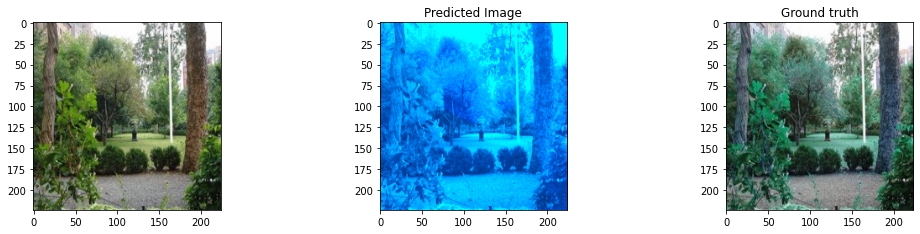

In [60]:
TestImagePath=data[4]
ImagePath=TestImagePath
# plt.imshow(cv2.imread(ImagePath))
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*110
Prediction=Prediction.reshape(224,224,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img_1 = cv2.imread(TestImagePath)
img_1 = cv2.resize(img_1, (224, 224))
img = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
# plt.imshow(img_)
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

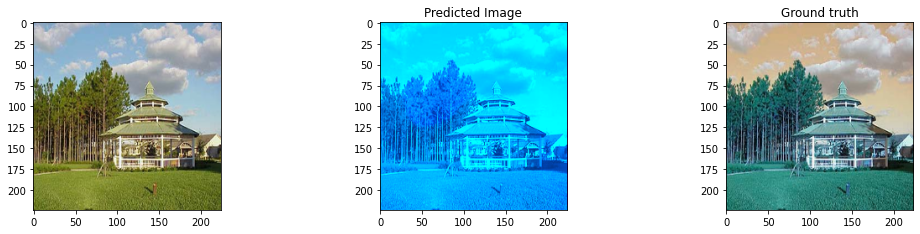

In [61]:
TestImagePath=data[9]
ImagePath=data[1]
# plt.imshow(cv2.imread(ImagePath))
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*110
Prediction=Prediction.reshape(224,224,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img_1 = cv2.imread(TestImagePath)
img_1 = cv2.resize(img_1, (224, 224))
img = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
# plt.imshow(img_)
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)